In [7]:
import sys

import numpy as np
from tqdm import tqdm

from src.common.log import logger
from src.dataset.tno_dataset_collection import TnoDatasetCollection
from src.inverse_problems.compressed_sensing_problem import SectorWiseCompressedSensingProblem
from src.inverse_problems.inverse_problems_solver import GenerativeModelSolver
from src.models.common.metrics import ssim, relative_error

In [8]:
MODEL_256 = "256"
MODEL_512 = "512"
MODEL_1024 = "1024"
MODEL_2048 = "2048"

SNR = None # no noise considered here
NUM_MEASUREMENTS = [5000]

In [9]:
dataset_collection = TnoDatasetCollection()

dataset = dataset_collection.test_data

dataset.disable_temporal_transforms()

[INFO] > Loading TNO data from '/home/must1d/Repositories/inventory-embeddings/data/TNO-GHGco-1km/TNO_by_city/TNO_GHGco_2015_highres_by_city.csv'
[INFO] > Loading TNO data from '/home/must1d/Repositories/inventory-embeddings/data/TNO-GHGco-1km/TNO_by_city/TNO_GHGco_2018_highres_by_city.csv'
[INFO] > Test Set has 13 unique cites!                           
	Dresden, Prague, Großzschocher, Győr, Innsbruck, Reims, Gdynia, Hamburg, Magdeburg, Aachen, Duisburg, Siegen, Szczecin
[INFO] > Validation Set has 15 unique cites!
	Koblenz, Ingolstadt, Southampton, Bielefeld, Linz, Bydgoszcz, Frankfurt am Main, Kalisz, Brussels, Wałbrzych, Erfurt, Zielona Góra, Angers, Kassel, Nijmegen
[INFO] > Training Set has 74 unique cites!
	Köln, Mannheim, Le Mans, Brighton, Vienna, Nantes, Regensburg, Amsterdam, Lille, Bremen, Le Havre, Odense, Ostrava, Wrocław, Freiburg, Charleroi, Antwerpen, Gorzów Wielkopolski, Ipswich, Sheffield, Eindhoven, Reading, Augsburg, Rotterdam, Copenhagen, Saint Peters, Trier, Bre

In [10]:
solvers = {
    MODEL_256: GenerativeModelSolver.from_vae_model_name(MODEL_256, plot_loss=True),
    MODEL_512: GenerativeModelSolver.from_vae_model_name(MODEL_512, plot_loss=True),
    MODEL_1024: GenerativeModelSolver.from_vae_model_name(MODEL_1024, plot_loss=True),
    MODEL_2048: GenerativeModelSolver.from_vae_model_name(MODEL_2048, plot_loss=True),
}

In [11]:
l2_relative_errors_results: dict[str, dict[int, list[float]]] = {} # Model Name -> Num Measurements -> Relative Error (per test datapoint)
ssim_results: dict[str, dict[int, list[float]]] = {} # Model Name -> Num Measurements -> SSIM (per test datapoint)

for mode_name in solvers.keys():
    l2_relative_errors_results[mode_name] = {}
    ssim_results[mode_name] = {}

    for num_measurements in NUM_MEASUREMENTS:
        l2_relative_errors_results[mode_name][num_measurements] = []
        ssim_results[mode_name][num_measurements] = []

KeyboardInterrupt: 

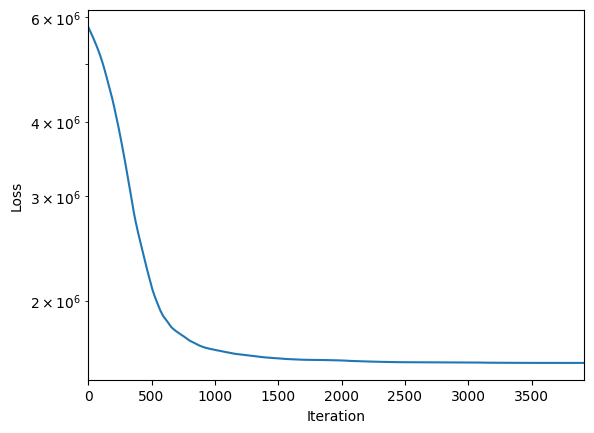

In [12]:
num_reconstructions = len(NUM_MEASUREMENTS) * len(dataset) * len(solvers)

with tqdm(total=num_reconstructions, leave=False, desc="Evaluation", file=sys.stdout) as bar:
    for num_measurements in NUM_MEASUREMENTS:
        for x in dataset:
            problem = SectorWiseCompressedSensingProblem.generate_random_sector_wise_measurements(x=x, num_measurements=num_measurements, snr=SNR)
            
            for solver_name, solver in solvers.items():
                x_rec = problem.solve(solver)
                l2_relative_errors_results[solver_name][num_measurements].append(relative_error(x, x_rec).item())
                ssim_results[solver_name][num_measurements].append(ssim(x, x_rec).item())
                
                bar.update()

In [ ]:
logger.info(np.array(ssim_results[MODEL_256][10000]).mean())
logger.info(np.array(ssim_results[MODEL_512][10000]).mean())
logger.info(np.array(ssim_results[MODEL_1024][10000]).mean())
logger.info(np.array(ssim_results[MODEL_2048][10000]).mean())